In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Read data
df_density = pd.read_excel('../../density.xlsx')
df_data = pd.read_csv('../data/coople_11072023.csv')
df_lat = pd.read_csv('../../post-codes.csv')
df_population = pd.read_excel('../../population.xlsx')

/Users/guan/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [2]:
df_population = df_population.iloc[3:,:2]
df_population = df_population.rename(columns={'su-e-01.02.03.07': 'Post Code','Permanent resident population by postal code, category of citizenship, sex, five-year age class and marital status, on 31.12.2022':'Population'})
df_density = df_density.drop(['Population','Density'],axis=1)

In [3]:
df_density = df_density.merge(df_population,on='Post Code',how='left')
df_density['Density'] = df_density['Population']/df_density['Area']
df_density.head()

,Post Code,City,Region,Area,Population,Density
0,1000,Lausanne,Vaud,14.100,4072,288.794326
1,1001,Lausanne,Vaud,NaN,NaN,NaN
2,1002,Lausanne,Vaud,NaN,NaN,NaN
3,1003,Lausanne,Vaud,0.820,6707,8179.268293
4,1004,Lausanne,Vaud,2.272,31230,13745.598592


In [4]:
df_density.to_csv('../../density.csv')

In [5]:
df_urban = df_data.merge(df_density, on = 'Post Code',how = 'left')
df_urban.set_index('Rank', inplace=True)

In [6]:
df_urban = df_urban.drop(['City_y'],axis=1)
df_urban = df_urban.rename(columns={'City_x': 'City'})
df_urban = df_urban.dropna(subset = ['Density'])
df_urban_lat = df_urban.merge(df_lat.drop_duplicates(['Post Code']), on = 'Post Code',how = 'left')
df_urban.head()

,Job role,Experience Level,Experience detail,Job description,Industry,City,Post Code,Pay total,Pay per hour,Start date,Shift,Region,Area,Population,Density
Rank,,,,,,,,,,,,,,,
1,Verkaufsmitarbeiter/in / Detailhandel,Ungelernt,Verkaufsmitarbeiter/in mit Freude am Verkauf u...,Aufgaben:\n- Auffülltätigkeiten (Non Food Bere...,Detailhandel / Logistik,Rüschlikon,8803,7695.00,27.00,8 Nov 2023,38,Canton of Zürich,4.632,6224,1343.696028
2,Koch/Köchin,Gelernt,Personen mit eidgenössischem Fähigkeitsausweis...,"Tournant, Einsatz ab 1. November bis 30. Novem...",Gastronomie / Hotel,Thun,3604,6037.50,35.00,8 Nov 2023,23,Canton of Bern,3.376,15478,4584.71564
4,Eventmanagement & Assistenz,Praxiserfahrung >20 Monate oder mit Ausbildung,Erfahrung von mehr als 20 Monaten im Eventmana...,We will be managing two locations in Allschwil...,Promotion / Event,Kanton Reinach,4153,18720.00,32.00,8 Nov 2023,78,Basel-Landschaft,7.000,19703,2814.714286
4,Eventmanagement & Assistenz,Praxiserfahrung >20 Monate oder mit Ausbildung,Erfahrung von mehr als 20 Monaten im Eventmana...,We will be managing two locations in Allschwil...,Promotion / Event,Kanton Reinach,4153,18720.00,32.00,8 Nov 2023,78,Basel-Landschaft,7.000,19703,2814.714286
5,Produktionsmitarbeiter/in,NaN,NaN,Bei der AG herrschen strenge Hygienevorschrift...,NaN,Rüti,8630,547.39,25.46,8 Nov 2023,3,Canton of Zürich,10.100,12703,1257.722772


In [7]:
density = df_urban['Density']
print(min(density),np.mean(density),max(density))

25.356125356125357 2711.9462413419974 16382.30884557721


In [8]:
df_urban['Urban'] = df_urban['Density'] > 400

In [9]:
urban_total = df_urban['Urban'].sum()/df_urban['Urban'].count()
urban_total

0.8920863309352518

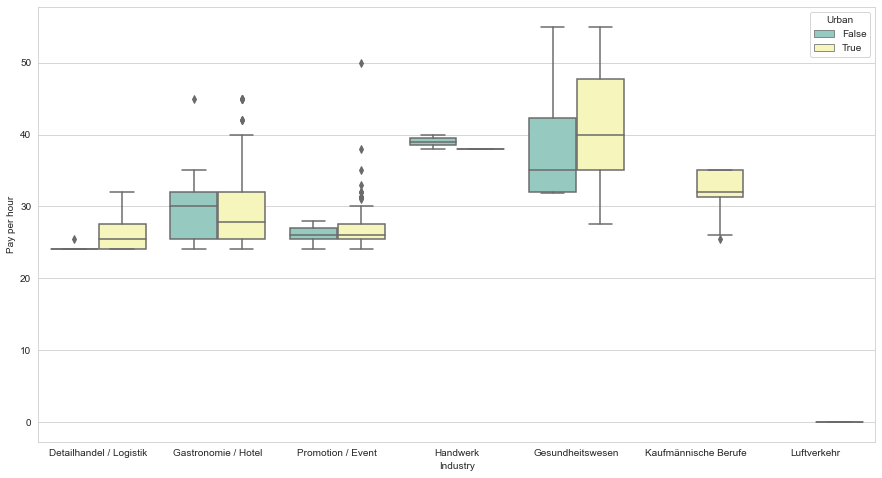

In [10]:
import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Industry", y="Pay per hour", hue="Urban", data=df_urban, palette="Set3")

In [11]:
# Urban data group by post code
df_count = df_urban.groupby(['Post Code']).size().reset_index(name = 'Counts')
df_count

,Post Code,Counts
0,1003,10
1,1006,1
2,1007,1
3,1023,1
4,1024,2
...,...,...
263,9450,2
264,9469,1
265,9475,2
266,9500,1


In [12]:
# Merge grouped by data with density.csv
df = df_count.merge(df_density,on = 'Post Code',how = 'left')
df['gig_per_capita'] = df['Counts']/df['Population']
# Define urban column
df['region'] = 'unknown'
df.loc[df['Density']<400, 'region'] = 'rural'
df.loc[(df['Density']>=400) & (df['Density']<1500), 'region'] = 'suburb'
df.loc[df['Density']>1500, 'region'] = 'urban'
df = df.rename(columns={'Counts': 'gig_num'})

df.head()

,Post Code,gig_num,City,Region,Area,Population,Density,gig_per_capita,region
0,1003,10,Lausanne,Vaud,0.820,6707,8179.268293,0.001491,urban
1,1006,1,Lausanne,Vaud,1.553,15391,9910.495815,0.000065,urban
2,1007,1,Lausanne,Vaud,3.904,22538,5773.053279,0.000044,urban
3,1023,1,NaN,Vaud,5.500,9200,1672.727273,0.000109,urban
4,1024,2,Chavannes-près-Renens,Vaud,4.829,13118,2716.504452,0.000152,urban


In [13]:
# Count job number of urban center, urban and rural 
urban_count = df.groupby('region')['region'].count()
urban_count

region
rural      54
suburb    117
urban     101
Name: region, dtype: int64

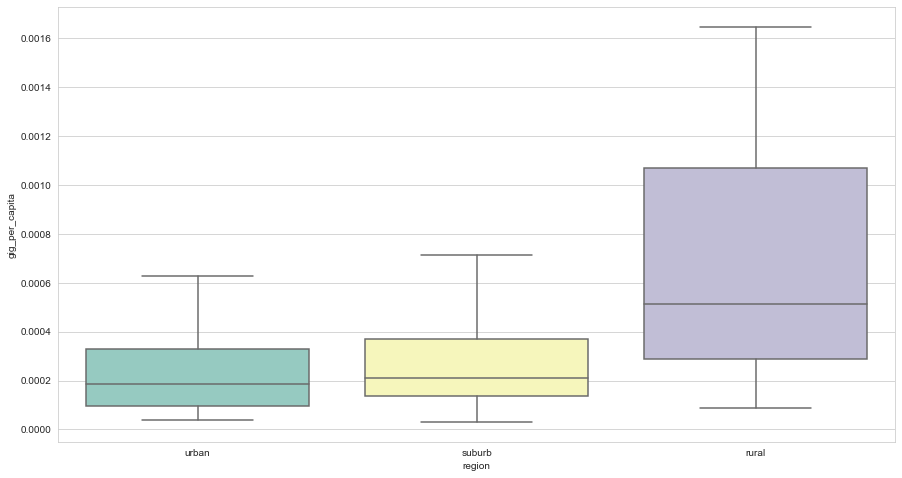

In [14]:
import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="region", y="gig_per_capita",               
data=df, palette="Set3",showfliers = False,order = ['urban','suburb','rural'])

In [15]:
suburb = df[df["region"]=='suburb']['gig_per_capita']
urban = df[df["region"]=='urban']['gig_per_capita']
rural = df[df["region"]=='rural']['gig_per_capita']

In [16]:
def hist_data(data):
    plt.hist(data, color = 'c', edgecolor='black',alpha=0.65,bins = 50)
    plt.axvline(data.mean(), color='r', linestyle='dashed', linewidth=1)
    plt.axvline(data.median(), color='b', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    plt.text(data.mean()*1.06, max_ylim*0.9, 'Mean: {:.2f}'.format(data.mean()))  
    plt.show()

In [17]:
def hist_all(labels,*data):
    plt.figure(figsize=(17,8))
    i = 0
    op = 0.7
    c = list(mcolors.BASE_COLORS.keys())
    plt.hist(data,color = c[:len(labels)], alpha=op-i*0.2,bins = 20, label = labels, range = [0,0.0085])
    plt.legend()
    plt.xlabel('gig per capita')
    plt.title(' vs. '.join(labels)+' histogram')
    plt.show()

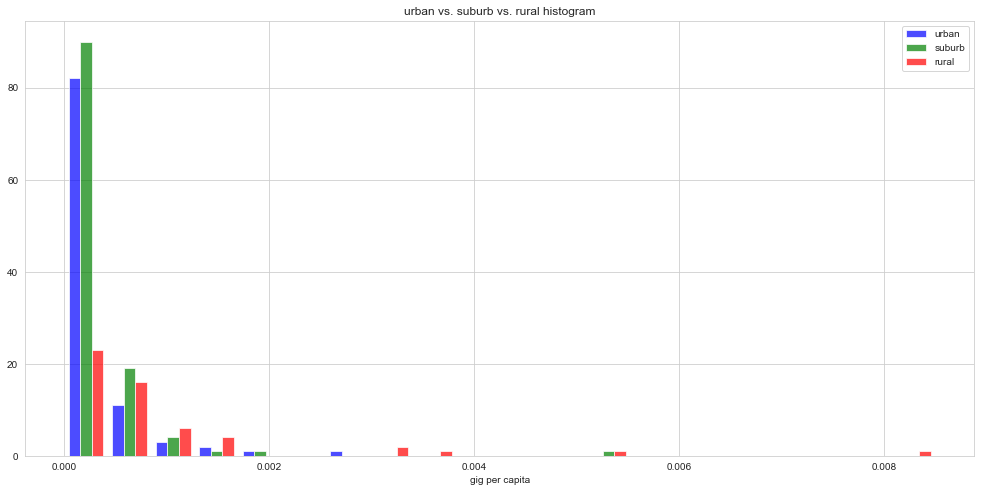

In [18]:
hist_all(['urban','suburb','rural'],urban,suburb,rural)

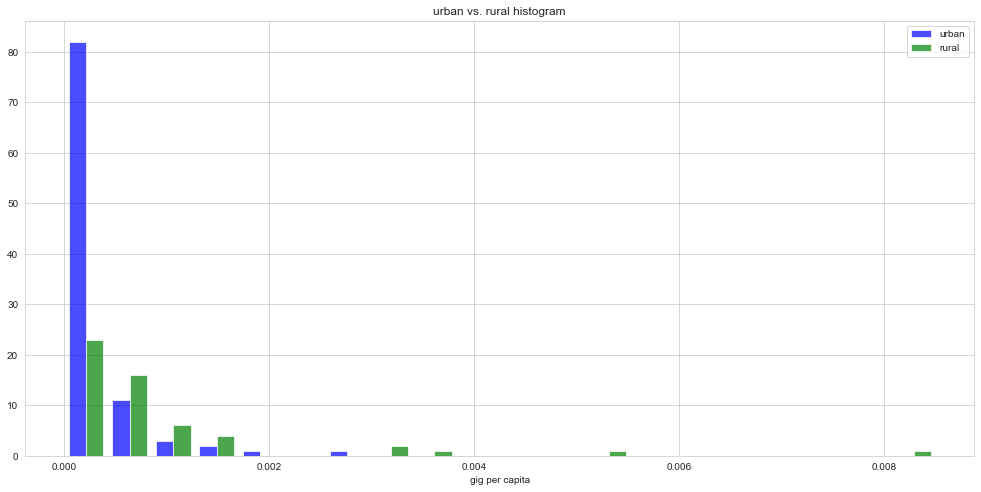

In [19]:
hist_all(['urban','rural'],urban,rural)

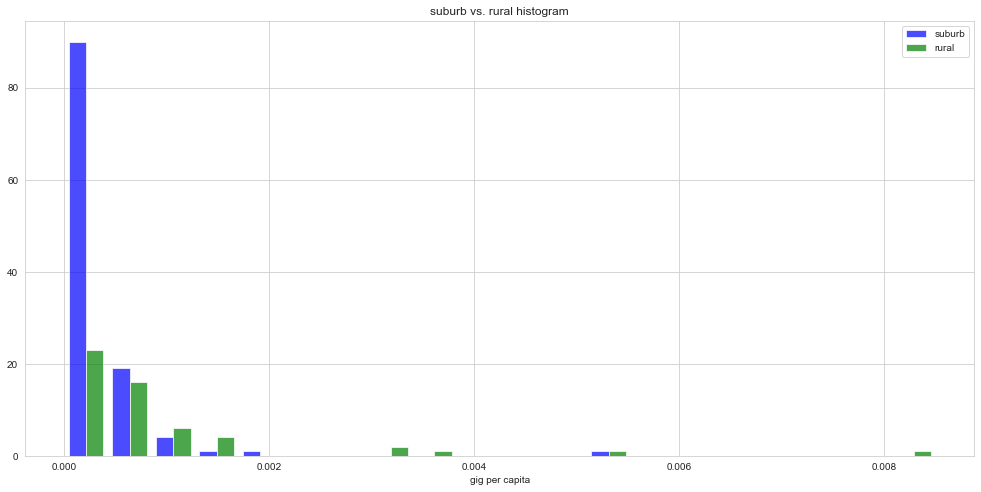

In [20]:
hist_all(['suburb','rural'],suburb,rural)

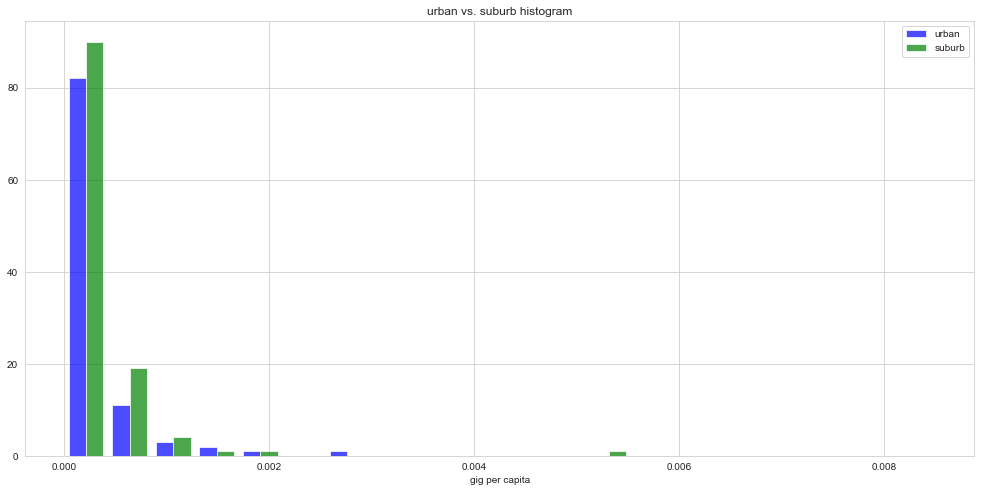

In [21]:
hist_all(['urban','suburb'],urban,suburb)

In [22]:
df_count = df_density.merge(df_count,on = 'Post Code', how = 'left')
df_count['Counts'] = df_count['Counts'].fillna(0)
df_count = df_count.drop(['City','Region'],axis=1)
df_count = df_count.dropna(subset = ['Density','Population'])
df_count['gig_per_capita'] = 100*df_count['Counts']/df_count['Population']
df_count = df_count.rename(columns={'Counts': 'gig_num'})
df_count

,Post Code,Area,Population,Density,gig_num,gig_per_capita
0,1000,14.100,4072,288.794326,0.0,0.0
3,1003,0.820,6707,8179.268293,10.0,0.149098
4,1004,2.272,31230,13745.598592,0.0,0.0
5,1005,1.585,12386,7814.511041,0.0,0.0
6,1006,1.553,15391,9910.495815,1.0,0.006497
...,...,...,...,...,...,...
3517,9411,5.100,701,137.45098,0.0,0.0
3519,9426,1.381,931,674.149167,0.0,0.0
3520,9427,6.900,1846,267.536232,0.0,0.0
3521,9428,7.000,1995,285.0,0.0,0.0


In [23]:
def draw_worker_density(xv,yv,df):
    plt.figure(figsize=(10, 6), dpi=80)
    ax = sns.scatterplot(x=xv, y=yv, data=df)
    ax.set_title('Coople')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel('log(density)')
    ax.set_ylabel('log(gig_per_capita)')

In [24]:
df.head()

,Post Code,gig_num,City,Region,Area,Population,Density,gig_per_capita,region
0,1003,10,Lausanne,Vaud,0.820,6707,8179.268293,0.001491,urban
1,1006,1,Lausanne,Vaud,1.553,15391,9910.495815,0.000065,urban
2,1007,1,Lausanne,Vaud,3.904,22538,5773.053279,0.000044,urban
3,1023,1,NaN,Vaud,5.500,9200,1672.727273,0.000109,urban
4,1024,2,Chavannes-près-Renens,Vaud,4.829,13118,2716.504452,0.000152,urban


In [32]:
from scipy import stats
def draw_corr(df,col1, col2):
    draw_worker_density(col1,col2,df)
    p = stats.pearsonr(np.log(df[col1].astype('float')), np.log(df[col2].astype('float')))
    s = stats.spearmanr(df[col1], df[col2])
    k = stats.kendalltau(df[col1], df[col2])
    print(f'Pearson r: {p[0]}, p value: {p[1]}')
    print(f'Spearman rho: {s[0]}, p value: {s[1]}')
    print(f'Kendall tau: {k[0]}, p value: {k[1]}')

Pearson r: -0.3865602675173078, p value: 3.9894945154402595e-11
Spearman rho: -0.3747854731160098, p value: 1.692135796609337e-10
Kendall tau: -0.26457180071637904, p value: 7.894876252691196e-11


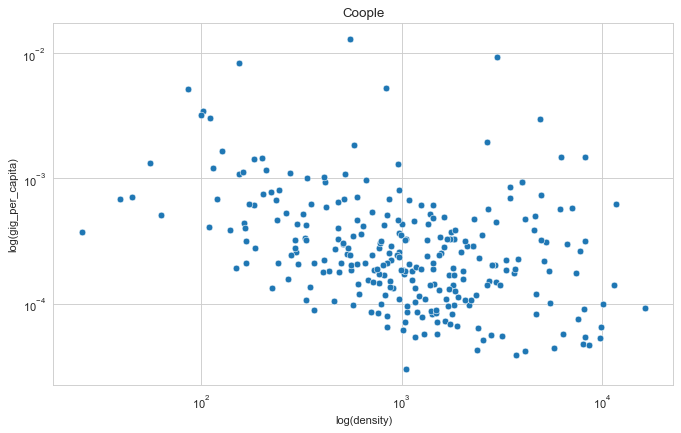

In [33]:
draw_corr(df,'Density','gig_per_capita')

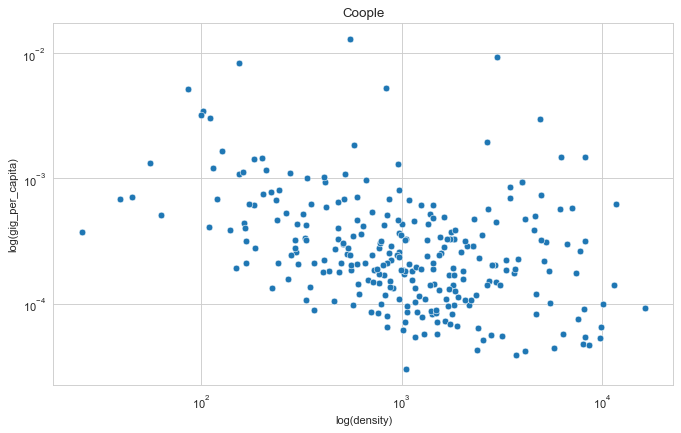

In [27]:
draw_worker_density('Density','gig_per_capita',df)

/Users/guan/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/guan/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4040: RuntimeWarning: invalid value encountered in subtract
  ym = y.astype(dtype) - ymean


ValueError: array must not contain infs or NaNs

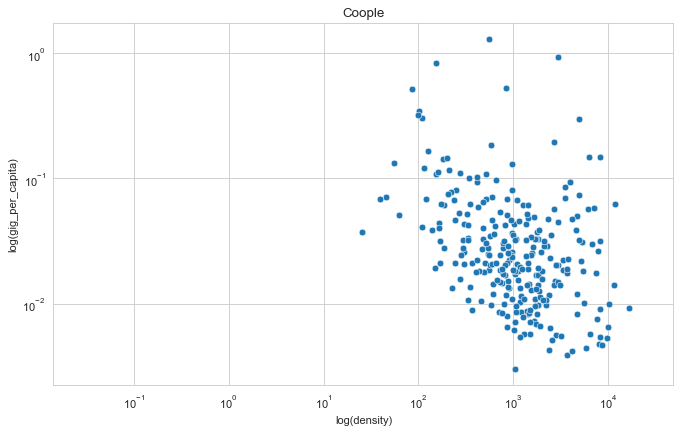

In [28]:
draw_corr(df_count,'Density','gig_per_capita')